In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import more libraries
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Introduction

This analysis will use data from the following study: https://www.cell.com/cell/fulltext/S0092-8674(15)01195-2/. It contains data of multiple omics and outcomes of 705 breast cancer patients. This notebook will not delve deep into the background the disease, how the data was acquired, or interpretation of results, but feel free to go through the paper further if you are curious.

# Section 1: Data Exploration

Let's open this data and look at the first few rows:

In [3]:
# Open the dataset
df = pd.read_csv("/kaggle/input/brca-multiomics-tcga/brca_data_w_subtypes.csv")

# View the first 5 rows
print(df.head())

   rs_CLEC3A    rs_CPB1  rs_SCGB2A2  rs_SCGB1D2    rs_TFF1   rs_MUCL1  \
0   0.892818   6.580103   14.123672   10.606501  13.189237   6.649466   
1   0.000000   3.691311   17.116090   15.517231   9.867616   9.691667   
2   3.748150   4.375255    9.658123    5.326983  12.109539  11.644307   
3   0.000000  18.235519   18.535480   14.533584  14.078992   8.913760   
4   0.000000   4.583724   15.711865   12.804521   8.881669   8.430028   

    rs_GSTM1     rs_PIP  rs_ADIPOQ   rs_ADH1B  ...  pp_p62.LCK.ligand  \
0  10.520335  10.338490  10.248379  10.229970  ...          -0.691766   
1   8.179522   7.911723   1.289598   1.818891  ...           0.279067   
2  10.517330   5.114925  11.975349  11.911437  ...           0.219910   
3  10.557465  13.304434   8.205059   9.211476  ...          -0.266554   
4  12.964607   6.806517   4.294341   5.385714  ...          -0.441542   

   pp_p70S6K  pp_p70S6K.pT389  pp_p90RSK  pp_p90RSK.pT359.S363  vital.status  \
0  -0.337863        -0.178503   0.011638  

In [4]:
print("Presenting the DataFrame:")
print("")
print("Variables: Four types of omics.")
print("Number of RNAseq variables:",
      len([match for match in df.columns if match.startswith("rs")]))
print("Number of Copy Number variables:",
      len([match for match in df.columns if match.startswith("cn")]))
print("Number of Mutation variables:",
      len([match for match in df.columns if match.startswith("mu")]))
print("Number of Protein variables:",
      len([match for match in df.columns if match.startswith("pp")]))

print("")
print("Outcomes: Five Outcomes.")
print("Vital Status:",df["vital.status"].unique())
print("Progesterone Receptors:",(df["PR.Status"]).unique())
print("Estrogen Receptors:",(df["ER.Status"]).unique())
print("HER2 Status",(df["HER2.Final.Status"]).unique())
print("Histological Cancer Subtype",(df["histological.type"]).unique())

Presenting the DataFrame:

Variables: Four types of omics.
Number of RNAseq variables: 604
Number of Copy Number variables: 860
Number of Mutation variables: 249
Number of Protein variables: 223

Outcomes: Five Outcomes.
Vital Status: [0 1]
Progesterone Receptors: ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
Estrogen Receptors: ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
HER2 Status ['Negative' nan 'Positive' 'Equivocal' 'Not Available']
Histological Cancer Subtype ['infiltrating ductal carcinoma' 'infiltrating lobular carcinoma']


This dataframe consists of a set of four types of omics and five outcomes for the patients. The omics are:

- mu: Whether a sonamic mutation (i.e., a mutation that happened after conception) is present for a gene.

- cn: Copy number of a part of the genome (i.e., amount of amplification of a part of the genome, this changes between different cells and individuals).

- rs: RNA-Seq.

- pp: Protein levels.

# Section 2: Single-gene study

We begin this analysis by looking at one specific gene, [MYH11](https://medlineplus.gov/genetics/gene/myh11/), a protein-encoding gene involved in cell movement and the transport of materials within and between cells.

In [5]:
# Isolate columns with information about this gene
df_myh11 = df[[col for col in df.columns if "MYH11" in col]]
print("MYH11 Variables:",list(df_myh11.columns))

MYH11 Variables: ['rs_MYH11', 'cn_MYH11', 'mu_MYH11', 'pp_MYH11']


We can ask ourselves whether information about this gene is predictive of patient survival.

In [6]:
for col in df_myh11.columns:

    # perform the t-test
    print("T-Test on relationship between %s and patient survival"%col)
    print("Mean in Dead:",df.loc[df["vital.status"]==0,col].mean())
    print("Mean in Alive:",df.loc[df["vital.status"]==1,col].mean())
    t_stat, p_val = ttest_ind(df.loc[df["vital.status"]==0,col],
                              df.loc[df["vital.status"]==1,col])

    # print the results
    print('T-statistic: ', t_stat)
    print('P-value: ', p_val)
    print("")

T-Test on relationship between rs_MYH11 and patient survival
Mean in Dead: 9.719396744663364
Mean in Alive: 10.716626617816441
T-statistic:  -3.8327667389375693
P-value:  0.00013806225200052157

T-Test on relationship between cn_MYH11 and patient survival
Mean in Dead: 0.4844517184942717
Mean in Alive: 0.6702127659574468
T-statistic:  -2.364841226624298
P-value:  0.018308480088894498

T-Test on relationship between mu_MYH11 and patient survival
Mean in Dead: 0.02618657937806874
Mean in Alive: 0.02127659574468085
T-statistic:  0.2805769132614428
P-value:  0.7791174742184606

T-Test on relationship between pp_MYH11 and patient survival
Mean in Dead: 0.41812203199222586
Mean in Alive: 0.37833229322340434
T-statistic:  0.21509916107455496
P-value:  0.8297523928463829



We find an association between both gene expression and copy number of MYH11 and patient survival. We can further ask ourselves whether the relationship between copy number and patient survival is completely mediated by gene expression:

In [7]:
# calculate effect of CN on status
model = LinearRegression(fit_intercept=True)
model.fit(df[["cn_MYH11"]], df["vital.status"])
cn_on_status = model.coef_[0]

# calculate effect of CN on RNASeq
model = LinearRegression(fit_intercept=True)
model.fit(df[["cn_MYH11"]], df["rs_MYH11"])
cn_on_rnaseq = model.coef_[0]

# calculate effect of RNASeq on status controlling for CN
model = LinearRegression(fit_intercept=True)
model.fit(df[["cn_MYH11","rs_MYH11"]], df["vital.status"])
cn_on_status_controlled = model.coef_[0]
rs_on_status_controlled = model.coef_[1]

print("Total Effect of CN on Status:",cn_on_status)
print("Direct Effect of CN on Status:",cn_on_status_controlled)
print("Mediated Effect of CN by RNAseq on Status:",cn_on_rnaseq*rs_on_status_controlled)

Total Effect of CN on Status: 0.042486679356786135
Direct Effect of CN on Status: 0.0401427450316438
Mediated Effect of CN by RNAseq on Status: 0.002343934325142337


We find in this case that actually the copy number isn't mediated by gene expression when affecting patient survival.

# Section 3: Clustering using Multi-Omics

Let's separate each omics into its own dataframe for clarity.

In [8]:
outcomes = df[["vital.status","PR.Status","ER.Status","HER2.Final.Status","histological.type"]]
df_mu = df[[col for col in df if col.startswith('mu')]]
df_cn = df[[col for col in df if col.startswith('cn')]]
df_rs = df[[col for col in df if col.startswith('rs')]]
df_pp = df[[col for col in df if col.startswith('pp')]]

[Somatic copy number variations](https://www.qiagen.com/mx/spotlight-pages/newsletters-and-magazines/articles/reviews-online-copy-number-alteration/) are prevalent in many types of cancer, and are part of what determines the type and prognosis of a tumour. Part of the mechanism of action is through changes in gene transcription levels (RNAseq), as [copy number and gene expression are highly correlated](https://bmcmedgenet.biomedcentral.com/articles/10.1186/s12881-019-0909-5). Let's look at those correlations:

In [9]:
# Calculate Pearson's correlation coefficients between copy number and RNA-seq data
correlation_matrix = np.corrcoef(df_cn, df_rs, rowvar=False)[:df_cn.shape[1], df_cn.shape[1]:]

# Create a dataframe from the correlation matrix
correlation_df = pd.DataFrame(correlation_matrix, index=df_cn.columns, columns=df_rs.columns)

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2000x2000 with 0 Axes>

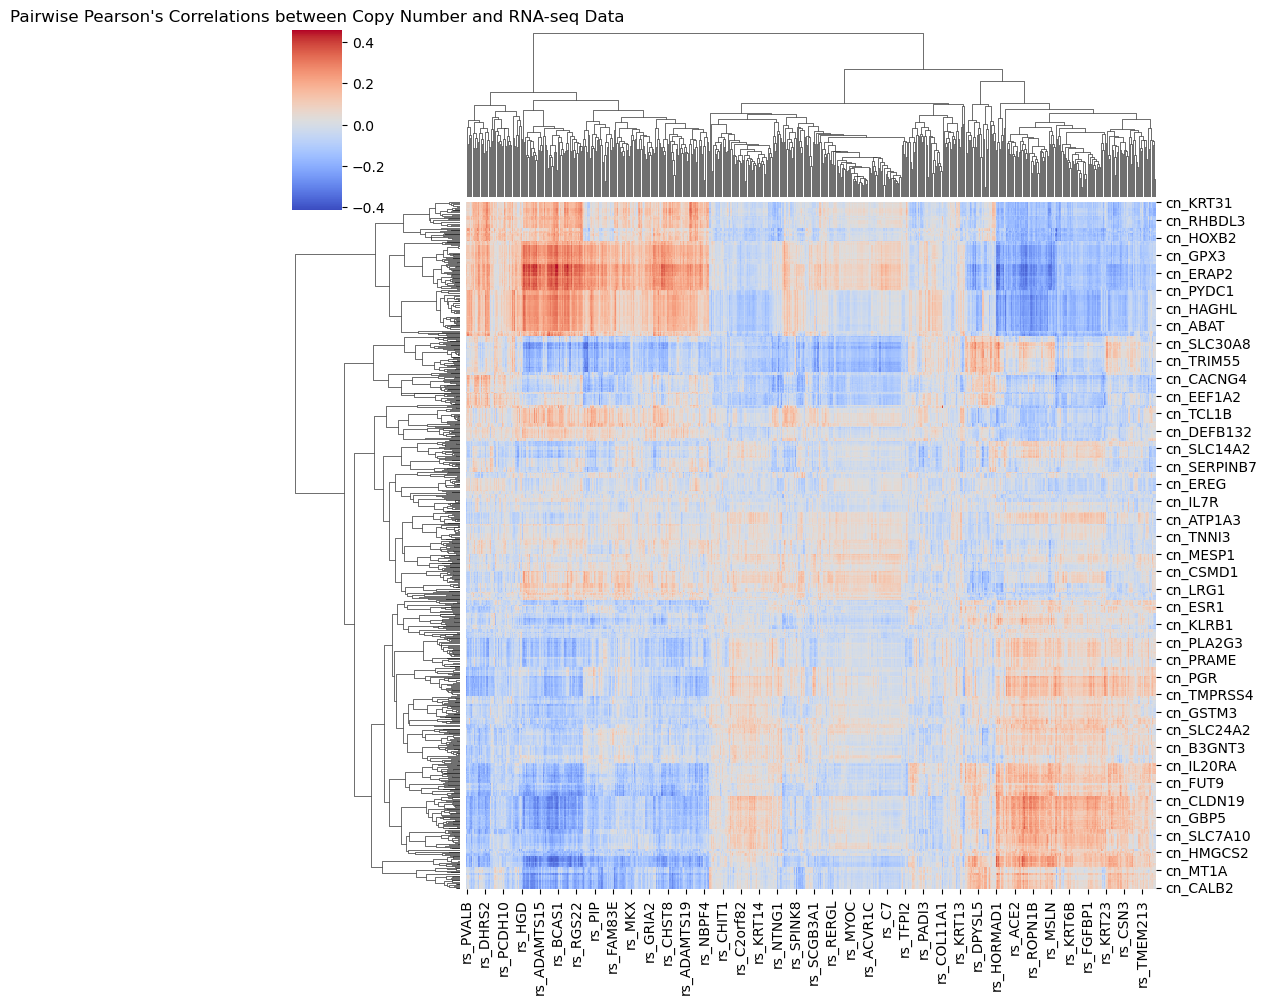

In [10]:
# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.clustermap(correlation_df, cmap="coolwarm")

# Customize plot appearance
plt.title("Pairwise Pearson's Correlations between Copy Number and RNA-seq Data")

# Show the plot
plt.show()

This is  difficult to interpret, but we can already see that there some clusters of copy number variations and gene expression are highly correlated, both positively and negatively. We want to know if the combination of omics here can help us know more about the outcomes or nature of the patient.

We start by reducing the dimensions of this data to 2 for visualisation, using principal component analysis:

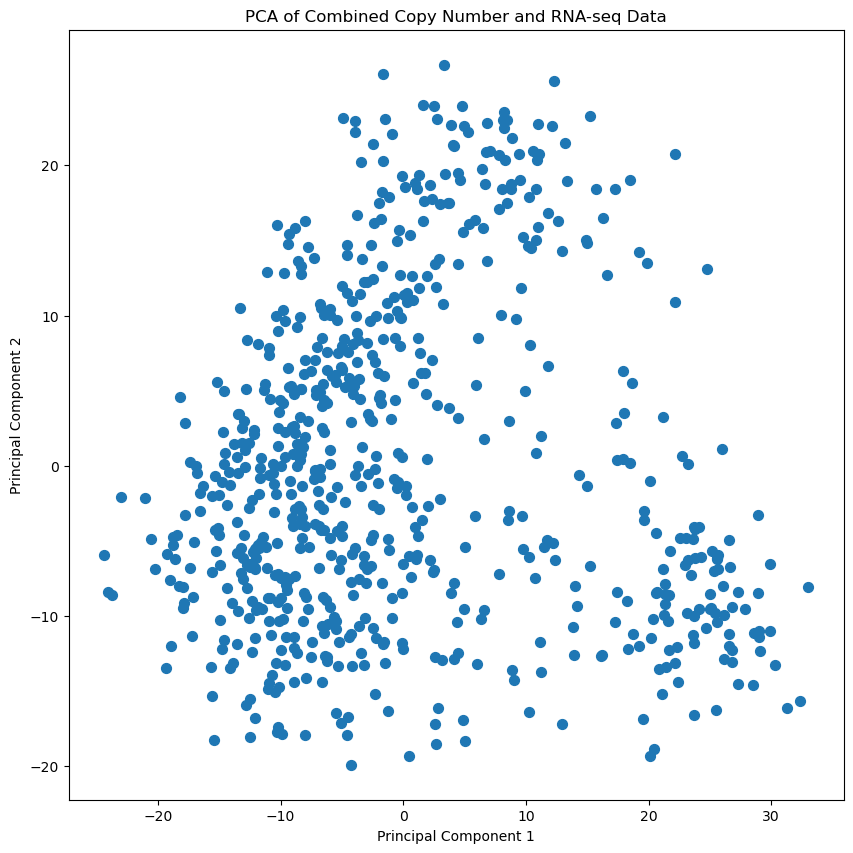

In [11]:
# Combine the dataframes
combined_data = pd.concat([df_cn,df_rs,df_mu,df_pp], axis=1)

# Standardize the combined data
standardized_data = (combined_data - combined_data.mean()) / combined_data.std()

# Apply PCA to reduce dimensionality
n_components = 2
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(standardized_data)

# Plot the reduced data
plt.figure(figsize=(10, 10))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=50)

# Customize plot appearance
plt.title("PCA of Combined Copy Number and RNA-seq Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Show the plot
plt.show()

We can start seeing different clusters in the data. Using KMeans clustering, we can divide the data further.

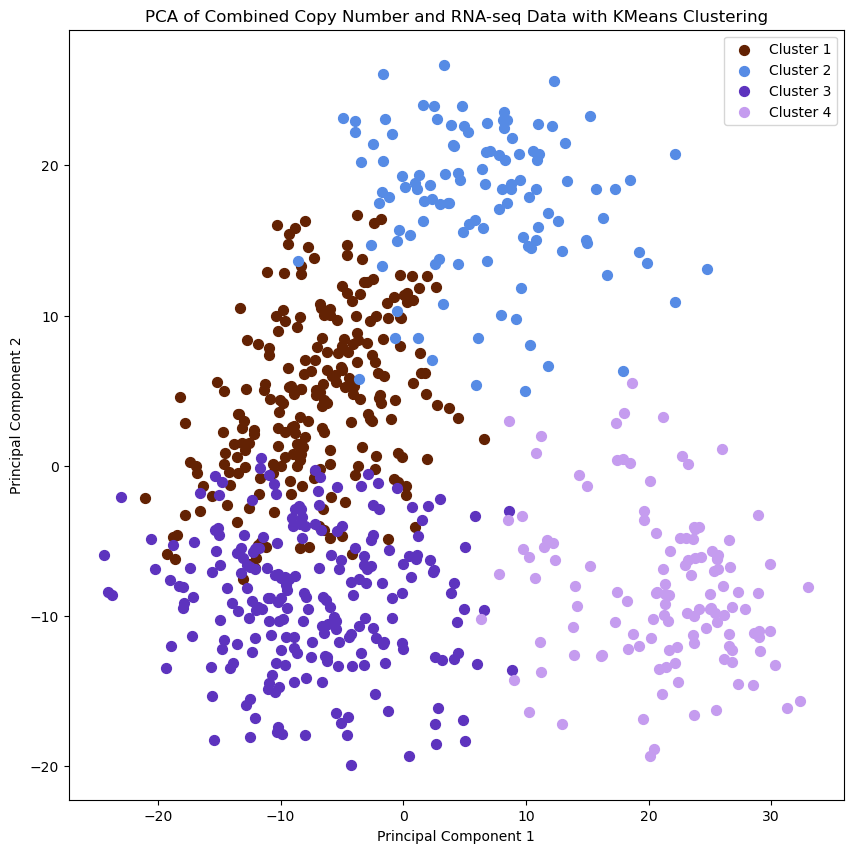

In [12]:
from sklearn.cluster import KMeans

# Apply PCA to reduce dimensionality
n_components = 2
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(standardized_data)

# Apply KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_assignments = kmeans.fit_predict(standardized_data)

# Generate set of colors for clusters
colors = []
for ii in range(n_clusters):
    colors.append("#{:06x}".format(np.random.randint(0, 0xFFFFFF)))

# Plot the reduced data with cluster colors
plt.figure(figsize=(10, 10))
for cluster in range(n_clusters):
    cluster_points = reduced_data[cluster_assignments == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, label=f"Cluster {cluster + 1}",color=colors[cluster])

# Customize plot appearance
plt.title("PCA of Combined Copy Number and RNA-seq Data with KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

# Show the plot
plt.show()

Is there any relationship between these clusters and survival?

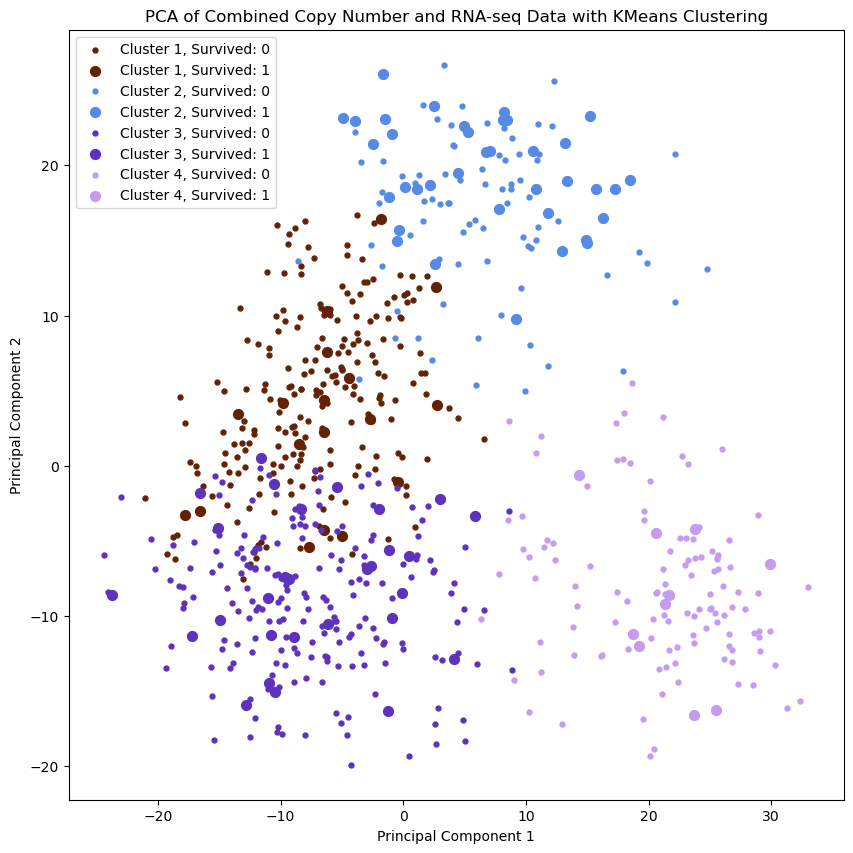

In [13]:
# Let's overlay survival rate on top of these clusters?

survived = (outcomes["vital.status"]).to_numpy()


# Define marker shapes for the survived array
marker_shapes = {0: '.', 1: 'o'}

# Plot the reduced data with cluster colors and different shapes for survived values
plt.figure(figsize=(10, 10))
for cluster in range(n_clusters):
    color = colors[cluster]
    for survived_value, marker_shape in marker_shapes.items():
        cluster_points = reduced_data[(cluster_assignments == cluster) & (survived == survived_value)]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, marker=marker_shape,
                    label=f"Cluster {cluster + 1}, Survived: {survived_value}",color=color)


# Customize plot appearance
plt.title("PCA of Combined Copy Number and RNA-seq Data with KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

# Show the plot
plt.show()

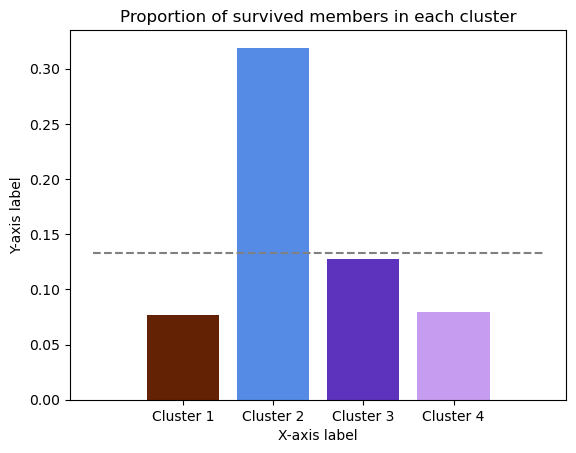

In [14]:
# Proportions of survival in each cluster
cluster_survival = []
for cluster in range(n_clusters):
    cluster_survival.append(np.sum((cluster_assignments==cluster)&(survived==1))/np.sum(cluster_assignments==cluster))

labels = []
for ii in range(n_clusters):
    labels.append("Cluster %i"%(ii+1))

# create a bar plot
plt.bar(labels, cluster_survival,color=colors)
# plot mean
plt.plot([-1,4],[np.mean(survived),np.mean(survived)],'--',color='gray')

# add a title to the plot
plt.title('Proportion of survived members in each cluster')

# add labels to the x and y axes
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')

# display the plot
plt.show()

Clearly being part of Cluster 2 is associated with survival. What about cancer type?

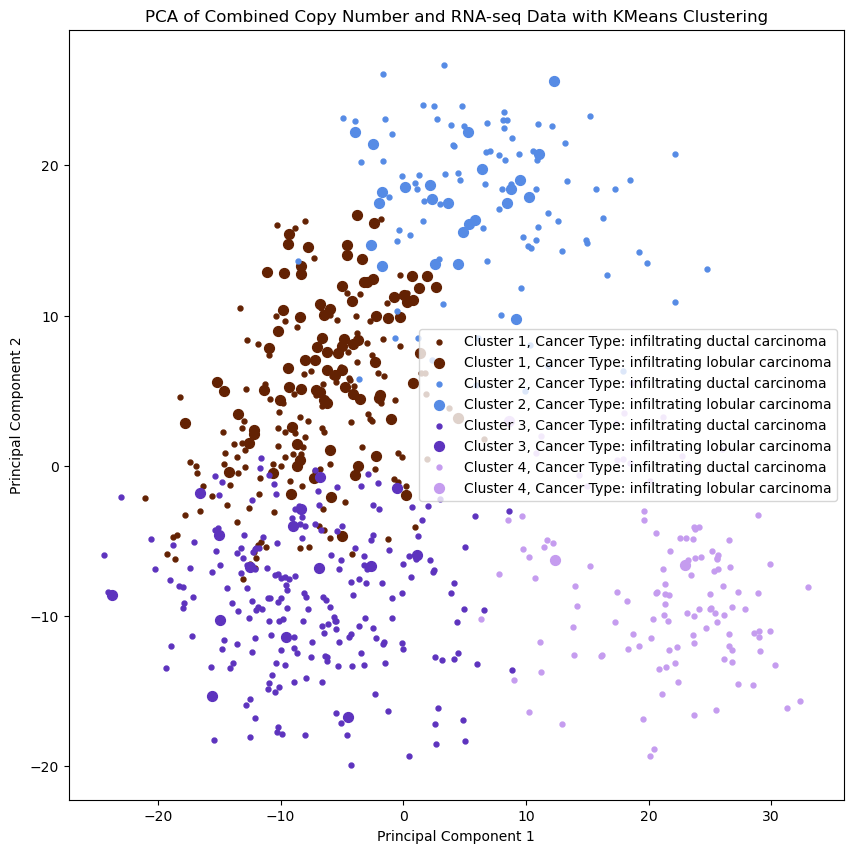

In [15]:
# Let's overlay cancer type on top of these clusters?
cancer_types_desc = ["infiltrating ductal carcinoma","infiltrating lobular carcinoma"]
cancer = (outcomes["histological.type"]).to_numpy()


# Define marker shapes for the cancer array
marker_shapes = {"infiltrating ductal carcinoma": '.', "infiltrating lobular carcinoma": 'o'}

# Plot the reduced data with cluster colors and different shapes for cancer values
plt.figure(figsize=(10, 10))
for cluster in range(n_clusters):
    color = colors[cluster]
    for cancer_value, marker_shape in marker_shapes.items():
        cluster_points = reduced_data[(cluster_assignments == cluster) & (cancer == cancer_value)]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, marker=marker_shape,
                    label=f"Cluster {cluster + 1}, Cancer Type: {cancer_value}",color=color)


# Customize plot appearance
plt.title("PCA of Combined Copy Number and RNA-seq Data with KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

# Show the plot
plt.show()

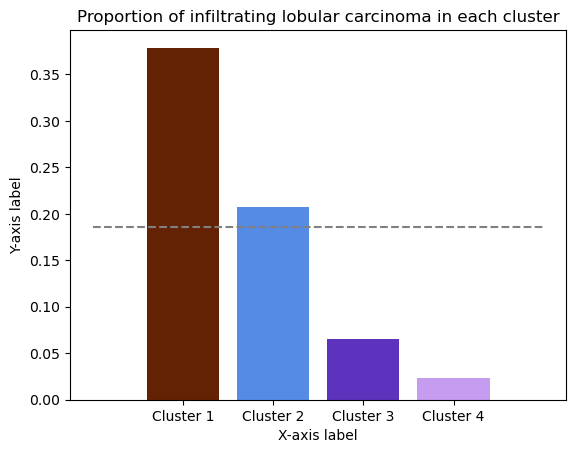

In [16]:
# Proportions of infiltrating lobular carcinoma in each cluster
cluster_survival = []
for cluster in range(n_clusters):
    cluster_survival.append(np.sum((cluster_assignments==cluster)&(cancer=="infiltrating lobular carcinoma"))/np.sum(cluster_assignments==cluster))
    
labels = []
for ii in range(n_clusters):
    labels.append("Cluster %i"%(ii+1))

# create a bar plot
plt.bar(labels, cluster_survival,color=colors)
# plot mean
plt.plot([-1,4],[np.mean(cancer=="infiltrating lobular carcinoma"),
                 np.mean(cancer=="infiltrating lobular carcinoma")],'--',color='gray')

# add a title to the plot
plt.title('Proportion of infiltrating lobular carcinoma in each cluster')

# add labels to the x and y axes
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')

# display the plot
plt.show()

It seems like Clusters 1 hase higher rates of infiltrating lobular carcinoma, while clusters 3 and 4 barely do.

You can try and run similar integration with the other omics, try other integration techniques, or look at the other patient outcomes.